In [1]:
%matplotlib inline
import os, shutil
import sys
sys.path.append("..")
import numpy as np
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt

import flopy as flopy
import pyemu

In [2]:
import freyberg_setup as fs
fs.setup_pest_pp()
working_dir = fs.WORKING_DIR_PP
pst_name = fs.PST_NAME_PP

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...

changing model workspace...
   freyberg_pp
FloPy is using the following executable to run the model: /Users/jeremyw/Dev/gw1876/activities/freyberg_ies/freyberg_pp/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.1, 7/21/2016                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 07/21/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/04/23  6:48:50

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater

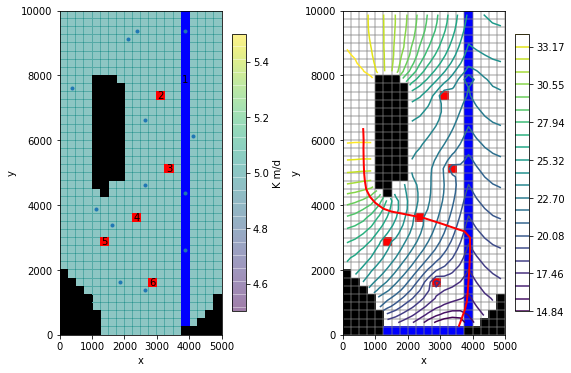

In [3]:
fs.plot_model(working_dir, pst_name)

In [4]:
# m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir,load_only=["upw"],check=False)
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
# obs = pst.observation_data
# #obs.loc[obs.obgnme=="calhead","weight"] = 0.75
# par = pst.parameter_data

# grid_groups = []
# grid_prefixes = ['hk','r0','r1','ss','sy']
# for prefix in grid_prefixes:
#     gr_par = par.loc[par.pargp==prefix].copy()
#     gr_par.loc[:,"i"] = gr_par.parnme.apply(lambda x: int(x.split('_')[1][1:]))
#     gr_par.loc[:,"j"] = gr_par.parnme.apply(lambda x: int(x.split('_')[2][1:]))
#     gr_par.loc[:,"x"] = m.sr.xcentergrid[gr_par.i,gr_par.j]
#     gr_par.loc[:,"y"] = m.sr.ycentergrid[gr_par.i,gr_par.j]
#     grid_groups.append(gr_par)


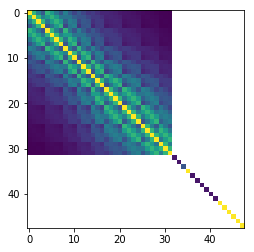

In [5]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500.0)
gs = pyemu.geostats.GeoStruct(variograms=v)
df_pp = pyemu.pp_utils.pp_tpl_to_dataframe(os.path.join(working_dir,"hkpp.dat.tpl"))
cov = pyemu.helpers.geostatistical_prior_builder(pst=pst,struct_dict={gs:df_pp},sigma_range=6)
cov.to_ascii(os.path.join(working_dir,"prior.cov"))
plt.imshow(np.ma.masked_where(cov.x==0,cov.x))

### run pestpp-ies

In [8]:
pst.pestpp_options = {"forecasts":pst.pestpp_options["forecasts"]}
pst.pestpp_options["ies_subset_size"] = 4
pst.pestpp_options["ies_lambda_mults"] = [0.1,1.0,10.0]
pst.pestpp_options["lambda_scale_fac"] = [0.95,1.1]
pst.pestpp_options["ies_num_reals"] = 20
#pst.pestpp_options["ies_reg_factor"] = 1.0
#pst.pestpp_options["parcov_filename"] = "prior.cov"
pst.control_data.noptmax = 4
pst.write(os.path.join(working_dir,pst_name))

In [9]:
os.chdir(working_dir)
pyemu.helpers.start_slaves(".","pestpp-ies",pst_name,num_slaves=15,master_dir=".")
os.chdir("..")

In [10]:
par = pd.read_csv(pst.filename.replace(".pst",".0.par.csv"),index_col=0)
par.columns = par.columns.map(str.lower)

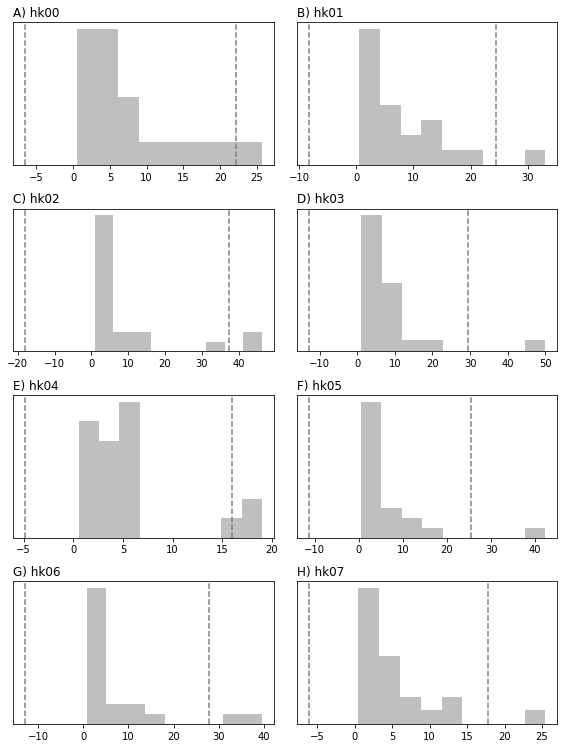

In [11]:
pyemu.plot_utils.ensemble_helper(par.iloc[:,:8])

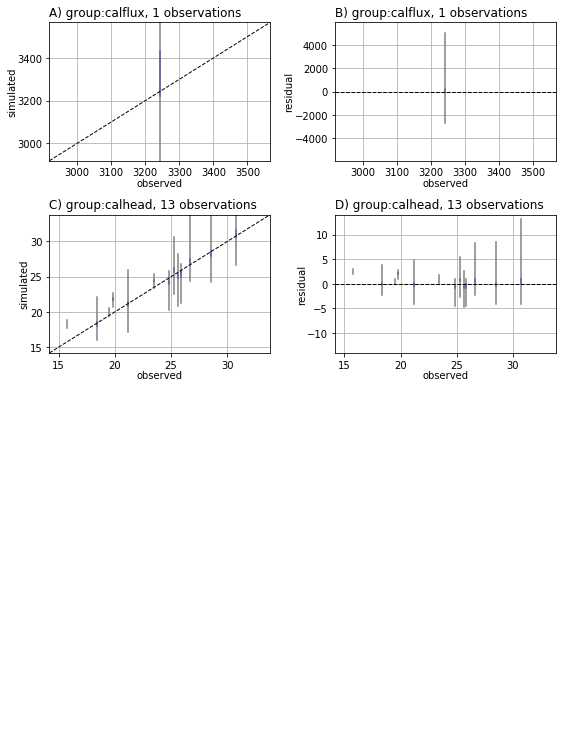

In [12]:
init_obs = pst.filename.replace(".pst",".0.obs.csv")
final_obs = init_obs.replace("0","{0}".format(pst.control_data.noptmax))
pyemu.plot_utils.ensemble_res_1to1({'0.5':init_obs,"b":final_obs},pst=pst)

In [13]:
init_df = pd.read_csv(init_obs,index_col=0)
init_df.columns = init_df.columns.map(str.lower)
final_df = pd.read_csv(final_obs,index_col=0)
final_df.columns = final_df.columns.map(str.lower)


In [14]:
pst.pestpp_options

{'forecasts': 'travel_time,fa_headwaters_0001,c001fr16c17_19791231,c001fr05c04_19791231',
 'ies_lambda_mults': [0.1, 1.0, 10.0],
 'ies_num_reals': 20,
 'ies_subset_size': 4,
 'lambda_scale_fac': [0.95, 1.1]}

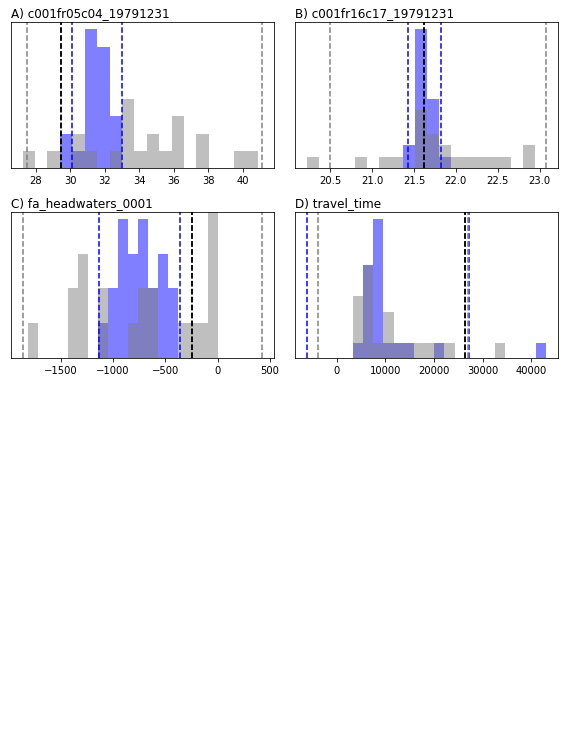

In [15]:
pyemu.plot_utils.ensemble_helper({"0.5":init_df.loc[:,pst.forecast_names],"b":final_df.loc[:,pst.forecast_names]},
                                 deter_vals=pst.observation_data.loc[pst.forecast_names,"obsval"].to_dict(),bins=20)